Analysis and modeling completed. Results and visualizations saved.


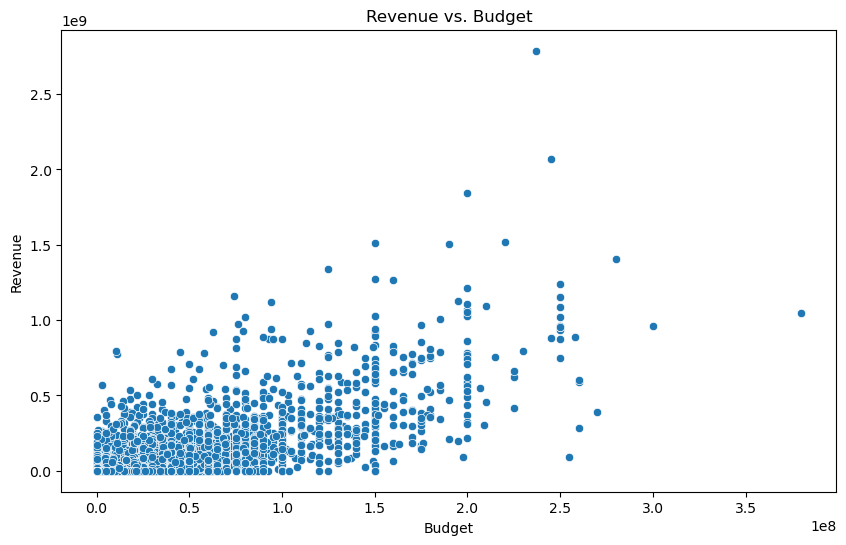

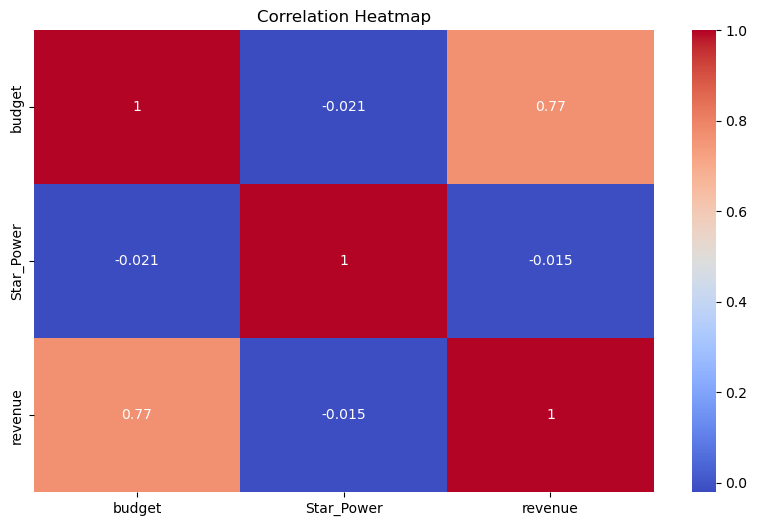

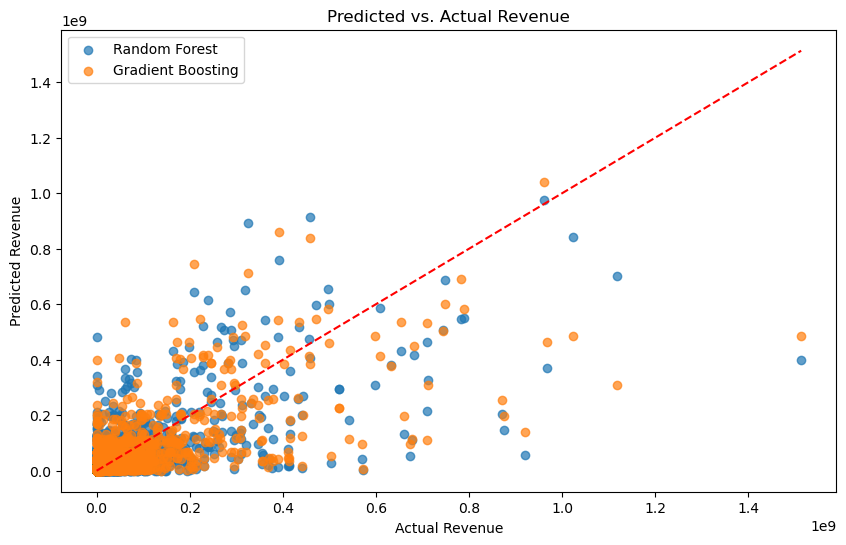

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from imdb import IMDb

# Load datasets
movies_metadata = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/The Movies Dataset/movies_metadata.csv", low_memory=False)
credits = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/The Movies Dataset/credits.csv")
keywords = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/The Movies Dataset/keywords.csv")
links = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/ml-25m/ml25 - links.csv")
ml_movies = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/ml-25m/ml25 - movies.csv")
ml_tags = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/ml-25m/ml25 - tags.csv")
ml_genome_scores = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/ml-25m/ml25 - genome-scores.csv")
ml_genome_tags = pd.read_csv("/Users/jwsue/Desktop/Bellevue/DSC680 – Applied Data Science/Milestone project 1 code/ml-25m/ml25 - genome-tags.csv")

# IMDbPY Integration: Fetch Box Office Data
ia = IMDb()
movie_ids = ['0133093', '0468569', '0120737']  # Replace with desired IMDb IDs
box_office_data = []

for movie_id in movie_ids:
    movie = ia.get_movie(movie_id)
    title = movie.get('title', 'N/A')
    year = movie.get('year', 'N/A')
    box_office = movie.get('box office', {})
    domestic_gross = box_office.get('Cumulative USA', 'N/A')
    worldwide_gross = box_office.get('Worldwide Gross', 'N/A')

    box_office_data.append({
        'Title': title,
        'Year': year,
        'Domestic Gross': domestic_gross,
        'Worldwide Gross': worldwide_gross
    })

box_office_df = pd.DataFrame(box_office_data)

# Data Cleaning and Preparation
movies_metadata = movies_metadata.rename(columns={'id': 'movie_id'})  # Rename 'id' to 'movie_id'
movies_metadata = movies_metadata[['movie_id', 'title', 'budget', 'revenue', 'genres']]
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce')
movies_metadata['revenue'] = pd.to_numeric(movies_metadata['revenue'], errors='coerce')
movies_metadata = movies_metadata.dropna(subset=['budget', 'revenue'])

# Align data types for merging
movies_metadata['movie_id'] = movies_metadata['movie_id'].astype(str)
credits = credits.rename(columns={'id': 'movie_id'})  # Rename 'id' to 'movie_id'
credits['movie_id'] = credits['movie_id'].astype(str)
keywords = keywords.rename(columns={'id': 'movie_id'})  # Rename 'id' to 'movie_id'
keywords['movie_id'] = keywords['movie_id'].astype(str)

# Merge datasets
merged_data = pd.merge(movies_metadata, credits[['movie_id', 'cast']], on='movie_id', how='left')
merged_data = pd.merge(merged_data, keywords[['movie_id', 'keywords']], on='movie_id', how='left')
merged_data = pd.merge(merged_data, box_office_df, left_on='title', right_on='Title', how='left')

# Feature Engineering: Star Power
def calculate_star_power(row):
    try:
        star_power = sum([ord(char) for char in row]) / len(row)
        return star_power
    except:
        return np.nan

merged_data['Star_Power'] = merged_data['cast'].apply(calculate_star_power)
merged_data['Star_Power'] = merged_data['Star_Power'].fillna(merged_data['Star_Power'].mean())

# Prepare features and target
features = ['budget', 'Star_Power']
X = merged_data[features]
y = merged_data['revenue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='budget', y='revenue')
plt.title("Revenue vs. Budget")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.savefig("scatter_budget_revenue.png")

plt.figure(figsize=(10, 6))
sns.heatmap(merged_data[features + ['revenue']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("correlation_heatmap.png")

# Modeling: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

# Modeling: Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))
gb_r2 = r2_score(y_test, gb_predictions)

# Save Results
results = pd.DataFrame({
    'Actual': y_test,
    'RF_Predicted': rf_predictions,
    'GB_Predicted': gb_predictions
})
results.to_csv("model_predictions.csv", index=False)

# Summary Visualizations
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, label="Random Forest", alpha=0.7)
plt.scatter(y_test, gb_predictions, label="Gradient Boosting", alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted vs. Actual Revenue")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.legend()
plt.savefig("predicted_vs_actual.png")

print("Analysis and modeling completed. Results and visualizations saved.")
